In [1]:
import numpy as np
from numpy import matlib as ml
import pandas as pd
import os
import warnings
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO
from pynwb.epoch import TimeIntervals

from sklearn.decomposition import PCA

import pdb

In [155]:
# ----- SET UP FILE HANDLING -----

# !! Josh -- you will need to edit this block with your local path to the NWB files
# You can/should just download the NWB folder from the Scn2a project Box, then you can just point to that directory here
# and everything should just work (haha famous last words)
# If we end up collaborating on files enough to make it stupid to switch back and forth between your computer(s) and mine,
# we can set up environmental variables that will take care of it, but for now this dumb kludge should be okay

# computer = 'Dorian'
# computer = 'Ernest'
computer = 'Josh'

if computer == 'Dorian':
    nwbpath = 'M:\\scn2a-paper-GWJSNH\\NWB-files'
    splitkey = '\\'
        
elif computer == 'Ernest':
        nwbpath = 'C:\\Users\\nhogl\\Documents\\GitHub\\scn2a-paper-GWJSNH-code\\NWB'
        splitkey = '\\'
elif computer ==  'Josh':
        nwbpath = '/Users/joshsteighner/Library/CloudStorage/Box-Box/Scn2a_X1Behavior_Nov22/NWB' # EDIT ME
        splitkey = '/'
allnwb = []
allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath) if each.endswith('.nwb')]

printy = True # EDIT ME if you don't want the loop over each file to print the file name

In [168]:
# ----- COLLATE TIME SPENT IN EACH STATE BEHAVIOR AND COUNTS OF EACH POINT BEHAVIOR FOR EACH ASSAY -----

# This cell looks in each NWB file and creates the summary metrics.  The idea is to do this once at the beginning then
# reconfigure the resulting dataframe for all subsequent analyses.  I did not functionalize it because it should just
# happen once at the beginning, but it might bear refactoring if we want more flexibility on the metrics

for i,fname in enumerate(allnwb): # loop over files
    # open file
    io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
    nwbfile = io.read()
    
    # for sanity check, print out the name of the file being handled
    pathsplit = fname.split(splitkey)
    recstem = pathsplit[-1].strip('.nwb')
    if printy: # you can turn off filename printing by setting this to false
        print(recstem)
    
    # filter out files that should be excluded (edited from complete timelines)
    if nwbfile.lab_meta_data['vole_metadata'].exclude_flag == False: # Replaced timeline_complete
        # get basic inclusion info and assay type for each assay
        assay_metadata = pd.DataFrame({'ET': [nwbfile.subject.subject_id],
                                       'assay_type': [nwbfile.lab_meta_data['vole_metadata'].assay_type],
                                       'include': [not(nwbfile.lab_meta_data['vole_metadata'].exclude_flag)]})

        data = nwbfile.intervals['annotated_behavior'].to_dataframe() # convert annotation table to dataframe
        df = data.copy()
        df=df[df.behavior!='Start assay']
        # get counts of all events and add a column to label as such
        counts = df.groupby('behavior')['start_time'].count().reset_index(name='number')
        nrcountsentries = counts.shape[0]
        counts['metric_label'] = ['count']*nrcountsentries
        # do median duration for state events and add a column to label as such
        medians = df[df.atype=='STATE'].groupby(['behavior'])['duration'].apply(np.median).reset_index(name='number')
        nrmediansentries = medians.shape[0]
        medians['metric_label'] = ['median']*nrmediansentries
        combined = pd.concat([counts,medians]) # combine table
        # PPT label conversion
        if nwbfile.lab_meta_data['vole_metadata'].assay_type=='PPT':
            if nwbfile.lab_meta_data['vole_metadata'].assay_type__partner_chamber=='Left':
                combined.behavior.replace({'Left':'Partner'}, regex=True,inplace=True)
                combined.behavior.replace({'Right':'Stranger'}, regex=True,inplace=True)
            elif nwbfile.lab_meta_data['vole_metadata'].assay_type__partner_chamber=='Right':
                combined.behavior.replace({'Right':'Partner'}, regex=True,inplace=True)
                combined.behavior.replace({'Left':'Stranger'}, regex=True,inplace=True)
            else:
                print('Invalid value for partner chamber.')
        nrbehav = combined.shape[0]
        # add metadata labels
        combined['ET'] = [nwbfile.subject.subject_id]*nrbehav
        combined['sex'] = [nwbfile.subject.sex]*nrbehav
        combined['GT'] = [nwbfile.subject.genotype]*nrbehav
        combined['assay'] = [nwbfile.lab_meta_data['vole_metadata'].assay_type]*nrbehav
        
        if i==0:
            rundf = combined
            inclusiondf = assay_metadata
        else:
            rundf = pd.concat([rundf,combined])
            inclusiondf = pd.concat([inclusiondf,assay_metadata])
        
    else:
        #print('Incomplete timeline; skipping.')
        print('Assay excluded; skipping.')
        
# ----- ADJUST LABELS IN DATAFRAME AND CONVERT TO WIDE FORMAT FOR PCA -----

# add a column to cross reference behaviors to assays and metric
rundf['a-b-m'] = rundf['assay'].add('-').add(rundf['behavior']).add('-').add(rundf['metric_label'])

# rearrange table so that each individual has a row of data
wide = rundf.pivot(index=['ET','sex','GT'], columns='a-b-m', values='number')
assay_filter = inclusiondf.pivot(index='ET', columns='assay_type', values='include')
assay_filter = assay_filter.loc[:,['introduction','timedMating','PPT','reunion','aggression']] # adjust column order

# THIS STEP WILL BE A PROBLEM WITH ASSAYS THAT DON'T EXIST
# replace any missing values with zeros (as they did not occur)

assay_filter = assay_filter.fillna(False)
filled = wide.fillna(0)

# pull metadata out of indices
filled = filled.reset_index(level=['sex', 'GT'])

# generate master list of observations; inventory of which behaviors appear in which assays
allcols = filled.columns

/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair56_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair2_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair3_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair21_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair1_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair62_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair44_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair31_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair41_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair30_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair52_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair42_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair5_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair64_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair16_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair24_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair40_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair1_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair48_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair2_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair64_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair35_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair38_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair59_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair50_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair16_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair23_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair29_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair19_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair24_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair31_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair51_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair21_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair63_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair17_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair4_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair15_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair6_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair47_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair3_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair38_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair64_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair28_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair28_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair48_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair58_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair61_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair32_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair6_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair21_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair31_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair25_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair16_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair3_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair40_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair44_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair43_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair63_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair5_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair51_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair34_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair47_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair62_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair37_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair18_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair15_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair18_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair25_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair64_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair19_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair61_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair5_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair1_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair7_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair1_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair46_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair48_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair58_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair33_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair51_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair34_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair49_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair60_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair8_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair8_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair50_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair15_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair51_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair41_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair52_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair33_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair23_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair22_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair17_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair6_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair17_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair15_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair57_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair7_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair16_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair40_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair27_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair50_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair57_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair22_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair32_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair30_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair34_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair41_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair4_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair41_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair24_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair32_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair8_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair19_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair22_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair59_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair60_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair49_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair58_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair41_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair52_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair5_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair35_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair30_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair25_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair5_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair44_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair37_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair60_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair16_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair28_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair59_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair29_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair38_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair27_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair8_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair7_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair63_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair49_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair62_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair52_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair46_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair59_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair15_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair37_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair22_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair27_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair37_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair28_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair31_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair3_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair46_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair50_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair23_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair18_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair39_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair42_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair44_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair49_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair7_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair26_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair36_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair17_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair27_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair19_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair38_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair52_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair47_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair36_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair23_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair63_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair19_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair25_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair39_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair40_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair30_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair48_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair49_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair4_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair43_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair2_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair56_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair40_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair2_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair33_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair39_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair62_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair24_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair31_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair34_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair24_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair37_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair17_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair29_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair56_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair1_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair46_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair26_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair33_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair36_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair43_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair57_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair33_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair56_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair58_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair6_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair26_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair22_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair8_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair29_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair47_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair2_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair21_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair38_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair64_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair34_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair21_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair58_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair42_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair50_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair3_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair7_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair35_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair62_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair44_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair51_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair23_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair39_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair26_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair26_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair18_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair61_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair6_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair61_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair61_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair28_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair43_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair4_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair25_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair32_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair35_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair32_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair27_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair29_timedMating


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair57_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair47_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair57_PPT


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair56_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair43_aggressio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair36_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair48_introductio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair46_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair18_reunio


/Users/joshsteighner/opt/anaconda3/envs/scn2a/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Nov22_Pair30_timedMating


In [12]:
# ----- TAKE A LOOK AT THE RESULTING TABLE FOR SANITY CHECK -----
filled.head()

a-b-m,sex,GT,PPT-Attack Partner-count,PPT-Attack Stranger-count,PPT-Center-count,PPT-Center-median,PPT-Huddle Partner-count,PPT-Huddle Partner-median,PPT-Huddle Stranger-count,PPT-Huddle Stranger-median,...,timedMating-Investigate-median,timedMating-Mount-count,timedMating-Mount-median,timedMating-No interaction-count,timedMating-No interaction-median,timedMating-Sniff-count,timedMating-Sniff-median,timedMating-Strike-count,timedMating-Tussle-count,timedMating-Tussle-median
ET,,,,,,,,,,,,,,,,,,,,,
B6611,M,Het,0.0,0.0,260.0,0.9990,121.0,3.7490,11.0,1.5000,...,0.8740,52.0,0.7485,117.0,3.2460,84.0,1.3730,0.0,0.0,0.0
B6613,M,WT,0.0,1.0,236.0,2.2455,258.0,5.4970,93.0,2.9940,...,0.9990,52.0,0.7495,71.0,5.2510,94.0,1.4990,0.0,0.0,0.0
B6614,F,Het,1.0,0.0,330.0,0.9975,157.0,2.5030,103.0,1.7510,...,0.9965,0.0,0.0000,172.0,3.5005,33.0,0.9980,1.0,0.0,0.0
B6615,F,WT,0.0,0.0,82.0,2.6260,52.0,6.1260,2.0,5.6255,...,0.9960,0.0,0.0000,85.0,7.9990,20.0,1.2520,0.0,0.0,0.0
B6616,M,WT,0.0,1.0,380.0,1.4990,70.0,1.7465,74.0,2.7490,...,1.9160,14.0,0.8345,82.0,2.5030,46.0,1.7505,0.0,0.0,0.0


In [205]:
assay_filter.tail()

assay_type,introduction,timedMating,PPT,reunion,aggression
ET,,,,,
B8260,True,True,False,True,False
B8267,True,True,True,True,True
B8268,True,True,True,True,True
B8269,True,True,True,False,True
B8270,True,True,True,True,True


In [13]:
# ----- SET UP COLORS -----

# I have found that just hardcoding this is most effective in practice, will need to be subbed if we change the colors

acols = [[0.627451,   0.57254905, 0.37254903], # all colors
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2] # female colors, WT first
mcols = acols[2:] # male colors, WT first

fpal = sns.color_palette(fcols) # create seaborn palettes for plotting
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)

In [206]:
# ----- DEFINE DATA HANDLING FUNCTIONS ----

def check_column_labels(toUse,allCols):
    
    use = [] # keep track of which synthesized labels are represented
    
    for i,label in enumerate(toUse): # iterate over labels
        # check whether the label exists in the column list
        if label in allCols:
            use.append(label)
            
    return use

def generate_prospective_columns(useAssays,useBehaviors,useMetrics):
    
    # make all the label combinations out of the requested parts
    colsToUse = [assay+'-'+behav+'-'+metric for metric in useMetrics for behav in useBehaviors for assay in useAssays]
    
    return colsToUse

def validate_columns(assays,behaviors,metrics,columns):
    
    # generate labels
    cols_to_check = generate_prospective_columns(assays,behaviors,metrics)
    
    # and check for their presence in the actual columns
    checked = check_column_labels(cols_to_check,columns)
    
    return checked

def run_PCA_on_trimmed_data(useDF,useAssays,useBehaviors,useMetrics,useSex,numcomponents=2):
    
    # organize data for dimensionality reduction
    sexDF = useDF[useDF.sex==useSex]
    useCols = sexDF.columns
    useLabels = validate_columns(useAssays,useBehaviors,useMetrics,useCols)
    slicedDF = sexDF[useLabels].copy()

    # run PCA
    usePCA = PCA(n_components=numcomponents,whiten=True) # !! edit this for more components
    fitPCA = usePCA.fit(slicedDF).transform(slicedDF)
    
    print("("+useSex+") "+
        "explained variance ratio (first "+str(numcomponents)+" components): %s"
        % str(usePCA.explained_variance_ratio_))

#     pdb.set_trace()
    
    # add PCA values to dataframe
    for i in range(numcomponents):
        slicedDF['PCA'+str(i+1)] = fitPCA[:,i]
    slicedDF['GT'] = useDF.GT
    
    return slicedDF,fitPCA

def plot3dpca(pca_df, ax,usepal):
    for gt, plotcol in zip(['WT','Het'],usepal): ax.scatter(pca_df[pca_df['GT']==gt]['PCA1'],pca_df[pca_df['GT']==gt]['PCA2'],
                                                            pca_df[pca_df['GT']==gt]['PCA3'], c=[plotcol],alpha=1,label=gt)
    ax.legend()    
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')

explained variance ratio (first 3 components): [0.42101807 0.23835377 0.15838772]


Text(0.5, 1.0, 'PCA on intro, agression; all')

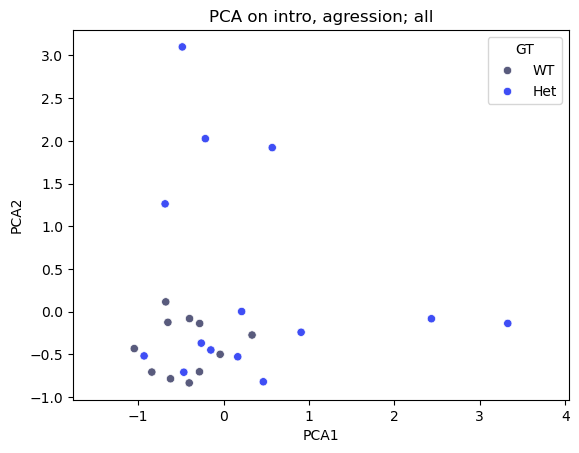

In [20]:
# set parameters for this analysis (stranger directed behaviors for males)
useBehaviors = ['Sniff','Investigate','Huddle','Tussle','Strike','Defensive strike','Mount','Intromission',
                  'Aggression receipt']
useAssays = ['introduction','aggression']
useMetrics = ['count','median']
useSex = 'M'

# do data handling and run PCA
(M_stranger_PCA_DF,M_stranger_PCA) = run_PCA_on_trimmed_data(filled,useAssays,useBehaviors,useMetrics,useSex,numcomponents=3)

# set up colors depending on target sex
if useSex=='M':
    usepal = mpal
else:
    usepal = fpal

# plotting
tp = sns.scatterplot(data=M_stranger_PCA_DF , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, agression; all')

(M) explained variance ratio (first 3 components): [0.42097814 0.2379119  0.16210767]
(F) explained variance ratio (first 3 components): [0.36149422 0.28619267 0.15756317]


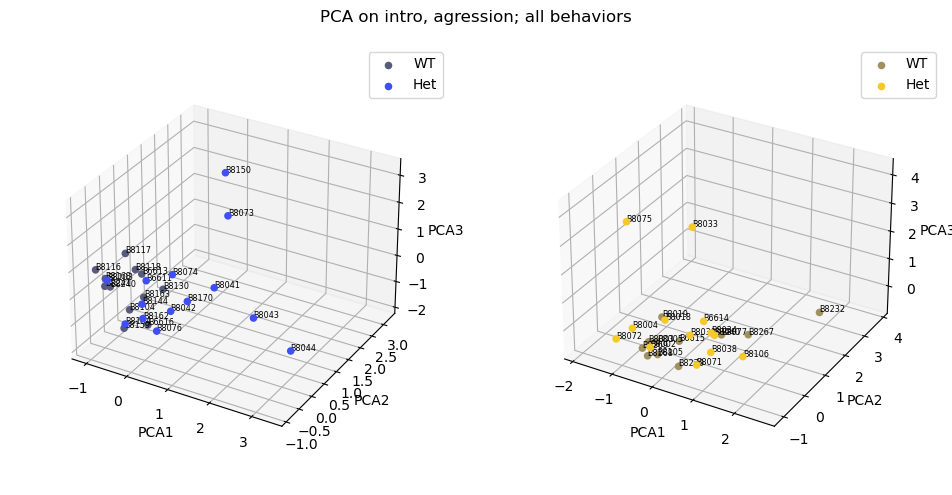

In [207]:
# set parameters for this analysis (stranger directed behaviors for males)
useBehaviors = ['Sniff','Investigate','Huddle','Tussle','Strike','Defensive strike','Mount','Intromission',
                  'Aggression receipt']
useAssays = ['introduction','aggression']
useMetrics = ['count','median']
filled_filtered = filled[assay_filter[useAssays].sum(axis=1)==len(useAssays)]


plot_ET = True
plot_sexes = ['M', 'F']

fig = plt.figure(figsize=(10,5))
fig.suptitle('PCA on intro, agression; all behaviors', fontsize=12)

for i in range(len(plot_sexes)):
    ax = fig.add_subplot(1, len(plot_sexes), i+1, projection='3d')
    useSex = plot_sexes[i]
    # do data handling and run PCA
    (stranger_PCA_DF,stranger_PCA) = run_PCA_on_trimmed_data(filled_filtered,useAssays,useBehaviors,useMetrics,useSex,numcomponents=3)
    # set up colors depending on target sex
    if useSex=='M':
        usepal = mpal
    else:
        usepal = fpal
    plot3dpca(stranger_PCA_DF, ax,usepal)
    ax.set_box_aspect(aspect=None, zoom=0.85)
    if plot_ET == True: 
        for row in stranger_PCA_DF.iterrows(): ax.text(row[1]['PCA1'],row[1]['PCA2'],row[1]['PCA3'],row[0],fontsize='xx-small')
fig.tight_layout()

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, reunion; all')

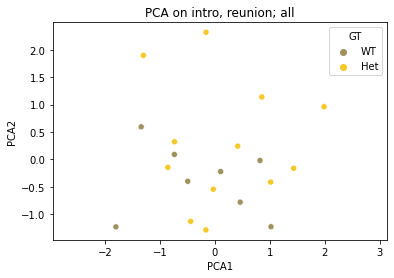

In [22]:
# set parameters for this analysis (partner directed behaviors for females)
useBehaviors = ['Sniff','Investigate','Huddle','Tussle','Strike','Defensive strike','Mount','Intromission',
                  'Aggression receipt']
useAssays = ['introduction','reunion']
useMetrics = ['count','median']
useSex = 'F'

# do data handling and run PCA
(F_partner_PCA_DF,F_partner_PCA) = run_PCA_on_trimmed_data(filled,useAssays,useBehaviors,useMetrics,useSex)

# set up colors depending on target sex
if useSex=='M':
    usepal = mpal
else:
    usepal = fpal

# plotting
tp = sns.scatterplot(data=F_partner_PCA_DF , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion; all')

(M) explained variance ratio (first 3 components): [0.47099176 0.28236572 0.14410916]
(F) explained variance ratio (first 3 components): [0.37390529 0.2854497  0.15402272]


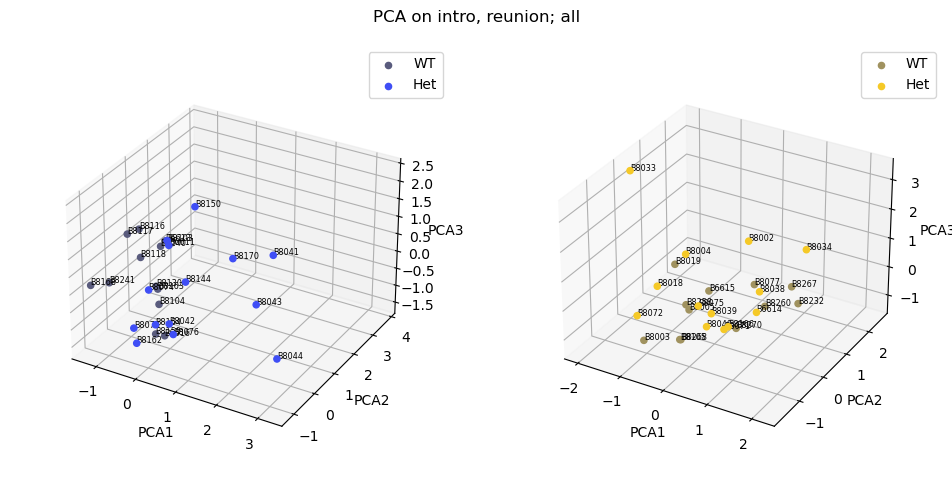

In [201]:
# set parameters for this analysis (partner directed behaviors for females)
useBehaviors = ['Sniff','Investigate','Huddle','Tussle','Strike','Defensive strike','Mount','Intromission',
                  'Aggression receipt']
useAssays = ['introduction','reunion']
useMetrics = ['count','median']

filled_filtered = filled[assay_filter[useAssays].sum(axis=1)==len(useAssays)]

plot_ET = True

plot_sexes = ['M', 'F']

fig = plt.figure(figsize=(10,5))
fig.suptitle('PCA on intro, reunion; all', fontsize=12)

for i in range(len(plot_sexes)):
    ax = fig.add_subplot(1, len(plot_sexes), i+1, projection='3d')
    useSex = plot_sexes[i]
    # do data handling and run PCA
    (partner_PCA_DF,partner_PCA) = run_PCA_on_trimmed_data(filled_filtered,useAssays,useBehaviors,useMetrics,useSex,numcomponents=3)
    # set up colors depending on target sex
    if useSex=='M':
        usepal = mpal
    else:
        usepal = fpal
    plot3dpca(partner_PCA_DF, ax,usepal)
    ax.set_box_aspect(aspect=None, zoom=0.85)
    if plot_ET == True: 
        for row in partner_PCA_DF.iterrows(): ax.text(row[1]['PCA1'],row[1]['PCA2'],row[1]['PCA3'],row[0],fontsize='xx-small')
fig.tight_layout()

(M) explained variance ratio (first 2 components): [0.38542629 0.25664148]


Text(0.5, 1.0, 'PCA on intro, timed mating, reunion, aggression; prosocial; counts only')

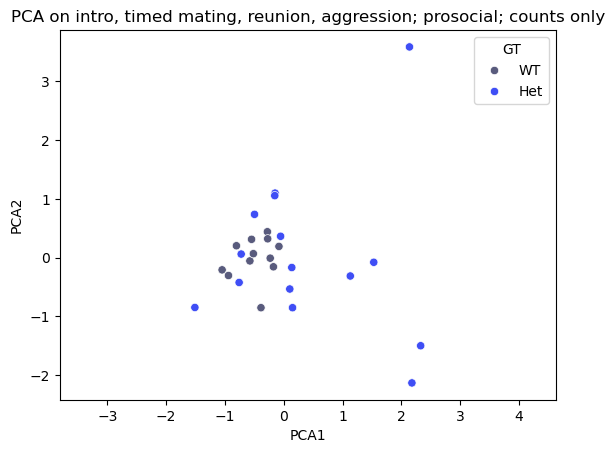

In [195]:
useBehaviors = ['Sniff','Investigate','Huddle']
useAssays = ['introduction','timedMating','reunion','aggression']
useMetrics = ['count']
useSex = 'M'

# do data handling and run PCA
(M_prosoc_PCA_DF,M_prosoc_PCA) = run_PCA_on_trimmed_data(filled,useAssays,useBehaviors,useMetrics,useSex)

# set up colors depending on target sex
if useSex=='M':
    usepal = mpal
else:
    usepal = fpal

# plotting
tp = sns.scatterplot(data=M_prosoc_PCA_DF , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, timed mating, reunion, aggression; prosocial; counts only')

(M) explained variance ratio (first 3 components): [0.37371098 0.26145846 0.13758539]
(F) explained variance ratio (first 3 components): [0.30877118 0.2159735  0.18740644]


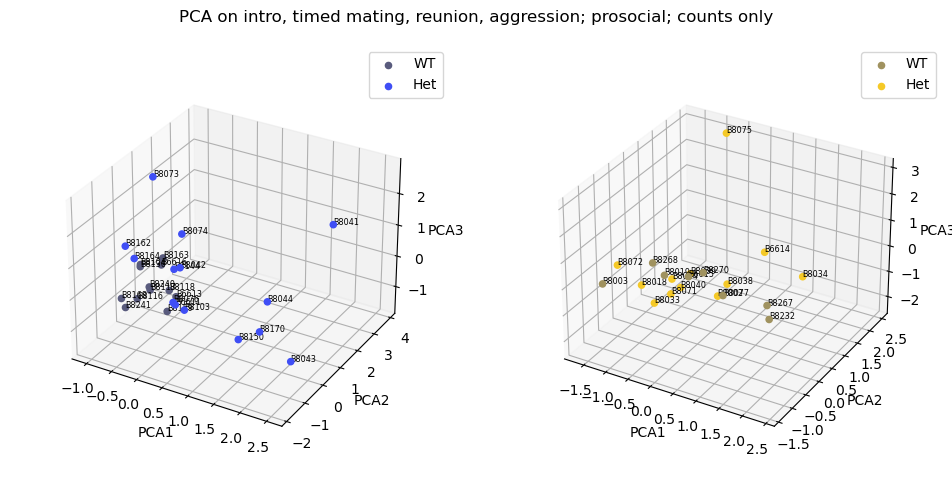

In [202]:
useBehaviors = ['Sniff','Investigate','Huddle']
useAssays = ['introduction','timedMating','reunion','aggression']
useMetrics = ['count']
plot_ET = True

filled_filtered = filled[assay_filter[useAssays].sum(axis=1)==len(useAssays)]

plot_sexes = ['M', 'F']

fig = plt.figure(figsize=(10,5))
fig.suptitle('PCA on intro, timed mating, reunion, aggression; prosocial; counts only', fontsize=12)

for i in range(len(plot_sexes)):
    ax = fig.add_subplot(1, len(plot_sexes), i+1, projection='3d')
    useSex = plot_sexes[i]
    # do data handling and run PCA
    (prosoc_PCA_DF,prosoc_PCA_PCA) = run_PCA_on_trimmed_data(filled_filtered,useAssays,useBehaviors,useMetrics,useSex,numcomponents=3)
    # set up colors depending on target sex
    if useSex=='M': usepal = mpal
    else: usepal = fpal
    plot3dpca(prosoc_PCA_DF, ax,usepal)
    ax.set_box_aspect(aspect=None, zoom=0.85)
    if plot_ET == True: 
        for row in prosoc_PCA_DF.iterrows(): ax.text(row[1]['PCA1'],row[1]['PCA2'],row[1]['PCA3'],row[0],fontsize='xx-small')
fig.tight_layout()

(M) explained variance ratio (first 3 components): [0.49310132 0.28668565 0.13533251]
(F) explained variance ratio (first 3 components): [0.84960143 0.12600879 0.01655321]


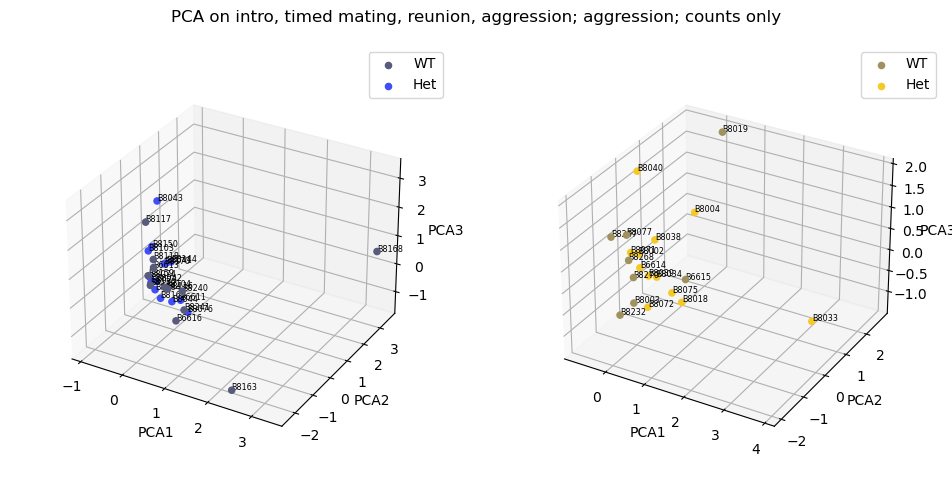

In [203]:
#useBehaviors = ['Tussle','Strike','Defensive strike','Aggression receipt']
useBehaviors = ['Tussle','Strike','Defensive strike']

useAssays = ['introduction','timedMating','reunion','aggression']
useMetrics = ['count']

plot_ET = True

filled_filtered = filled[assay_filter[useAssays].sum(axis=1)==len(useAssays)]

plot_sexes = ['M', 'F']

fig = plt.figure(figsize=(10,5))
fig.suptitle('PCA on intro, timed mating, reunion, aggression; aggression; counts only', fontsize=12)
for i in range(len(plot_sexes)):
    ax = fig.add_subplot(1, len(plot_sexes), i+1, projection='3d')
    useSex = plot_sexes[i]
    # do data handling and run PCA
    (aggr_PCA_DF,aggr_PCA_PCA) = run_PCA_on_trimmed_data(filled_filtered,useAssays,useBehaviors,useMetrics,useSex,numcomponents=3)
    # set up colors depending on target sex
    if useSex=='M': usepal = mpal
    else: usepal = fpal
    plot3dpca(aggr_PCA_DF, ax,usepal)
    ax.set_box_aspect(aspect=None, zoom=0.85)
    
    if plot_ET == True: 
        for row in aggr_PCA_DF.iterrows(): ax.text(row[1]['PCA1'],row[1]['PCA2'],row[1]['PCA3'],row[0],fontsize='xx-small')
fig.tight_layout()